In [ ]:
#Oussoubi Niakate-20242905|Jai-20045247|Konan Heney-20242603
#
#Runs without errors till the end

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Episode 388: Total Reward: -200.0
1/1 [==============================] - 0s 24ms/step
Episode 389: Total Reward: -200.0
1/1 [==============================] - 0s 26ms/step
Episode 390: Total Reward: -200.0
1/1 [==============================] - 0s 23ms/step
Episode 391: Total Reward: -200.0
1/1 [==============================] - 0s 25ms/step
Episode 392: Total Reward: -200.0
1/1 [==============================] - 0s 25ms/step
Episode 393: Total Reward: -200.0
1/1 [==============================] - 0s 24ms/step
Episode 394: Total Reward: -200.0
1/1 [==============================] - 0s 27ms/step
Episode 395: Total Reward: -200.0
1/1 [==============================] - 0s 30ms/step
Episode 396: Total Reward: -200.0
1/1 [==============================] - 0s 25ms/step
Episode 397: Total Reward: -200.0
1/1 [==============================] - 0s 27ms/step
Episode 398: Total Reward: -200.0
1/1

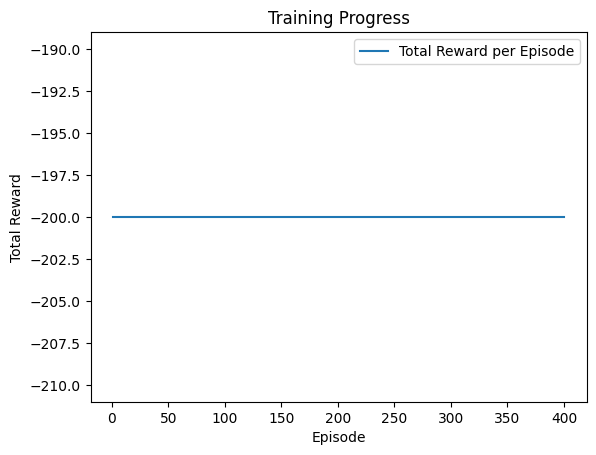

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import gym
import matplotlib.pyplot as plt
import random

# Environment
env = gym.make('MountainCar-v0')

# Define DQN model
class DQN(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        self.dense1 = layers.Dense(32, activation='relu')
        self.dense2 = layers.Dense(64, activation='relu')
        self.flatten = layers.Flatten()
        self.output_layer = layers.Dense(num_actions, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        x = self.flatten(x)
        return self.output_layer(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def add(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return zip(*random.sample(self.buffer, batch_size))

# DQN Agent
class DQNAgent:
    def __init__(self, num_actions):
        self.num_actions = num_actions
        self.model = DQN(num_actions)
        self.target_model = DQN(num_actions)
        self.target_model.set_weights(self.model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.batch_size = 16
        self.memory = ReplayBuffer(capacity=10000)

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q_values = self.model.predict(np.expand_dims(state, axis=0))
        return np.argmax(q_values)

    def train(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        target_q_values = self.target_model.predict(np.array(next_states))
        target_q_values[dones] = 0  # Q-value is 0 for terminal states
        target_q_values = rewards + self.gamma * np.max(target_q_values, axis=1)

        with tf.GradientTape() as tape:
            q_values = self.model(np.array(states))
            selected_action_q_values = tf.reduce_sum(q_values * tf.one_hot(actions, self.num_actions), axis=1)
            loss = tf.reduce_mean(tf.square(target_q_values - selected_action_q_values))

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

# Initialize DQN agent
num_actions = env.action_space.n
agent = DQNAgent(num_actions)

# Training loop with steps and episode-based approach
num_episodes = 400
steps_per_episode = 200  # Adjust the number of steps per episode based on your environment
total_rewards = []

for episode in range(1, num_episodes + 1):
    state = env.reset()
    state = np.reshape(state, [1, 2])

    total_reward = 0

    for step in range(1, steps_per_episode + 1):
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, 2])
        agent.memory.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.train()

        if done:
            break

    agent.update_target_model()

    total_rewards.append(total_reward)

    print("Episode {}: Total Reward: {}".format(episode, total_reward))

# Plotting the training progress
plt.plot(range(1, num_episodes + 1), total_rewards, label='Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Training Progress')
plt.legend()
plt.show()

# Close the environment
env.close()